# Some Fun Visualisations of the Tracked Marine Heatwaves

In [1]:
import xarray as xr
import numpy as np
import dask
from getpass import getuser
from pathlib import Path

import spot_the_blOb.helper as hpc
from spot_the_blOb.plotter import *

from matplotlib.colors import ListedColormap

In [ ]:
# Start Dask Cluster
client = hpc.StartLocalCluster(n_workers=16, n_threads=1)

In [3]:
# Import Tracked MHW DataSet
file_name = Path('/scratch') / getuser()[0] / getuser() / 'mhws' / 'MHWs_tracked.zarr'
blobs_ds = xr.open_zarr(str(file_name), chunks={})
blobs_ds

<xarray.Dataset> Size: 69GB
Dimensions:       (ID: 11605, time: 13879, lat: 721, lon: 1440, component: 2,
                   sibling_ID: 13)
Coordinates:
  * ID            (ID) int32 46kB 1 2 3 4 5 6 ... 11601 11602 11603 11604 11605
  * lat           (lat) float64 6kB -90.0 -89.75 -89.5 ... 89.5 89.75 90.0
  * lon           (lon) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * time          (time) datetime64[ns] 111kB 2002-01-01T23:59:00 ... 2039-12...
Dimensions without coordinates: component, sibling_ID
Data variables:
    ID_field      (time, lat, lon) int32 58GB dask.array<chunksize=(25, 721, 1440), meta=np.ndarray>
    area          (time, ID) float32 644MB dask.array<chunksize=(868, 726), meta=np.ndarray>
    centroid      (component, time, ID) float32 1GB dask.array<chunksize=(1, 868, 726), meta=np.ndarray>
    global_ID     (time, ID) int32 644MB dask.array<chunksize=(868, 726), meta=np.ndarray>
    merge_ledger  (time, ID, sibling_ID) int32 8GB dask.array<chunksize=(25, 11605, 13), meta=np.ndarray>
    presence      (time, ID) bool 161MB dask.array<chunksize=(868, 1451), meta=np.ndarray>
    time_end      (ID) datetime64[ns] 93kB dask.array<chunksize=(11605,), meta=np.ndarray>
    time_start    (ID) datetime64[ns] 93kB dask.array<chunksize=(11605,), meta=np.ndarray>
Attributes: (12/13)
    N_blobs_final:           11605
    N_blobs_unfiltered:      311435
    R_fill:                  8
    T_fill:                  2
    accepted_area_fraction:  0.9172714835387928
    allow_merging:           1
    ...                      ...
    area_threshold:          750.0
    multi_parent_merges:     6221
    nn_partitioning:         1
    overlap_threshold:       0.5
    rejected_area_fraction:  0.08272851646120712
    total_merges:            27270

In [4]:
# Extract the MHW ID Field
blobs = blobs_ds.ID_field
blobs

<xarray.DataArray 'ID_field' (time: 13879, lat: 721, lon: 1440)> Size: 58GB
dask.array<open_dataset-ID_field, shape=(13879, 721, 1440), dtype=int32, chunksize=(25, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 6kB -90.0 -89.75 -89.5 -89.25 ... 89.5 89.75 90.0
  * lon      (lon) float64 12kB 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * time     (time) datetime64[ns] 111kB 2002-01-01T23:59:00 ... 2039-12-31T2...

## Make a Nice Blobby Movie
N.B.: Making `dask`-powered movies using `pplot_mov()` cannot be threaded !

In [ ]:
plot_dir = Path('/scratch') / getuser()[0] / getuser() / 'mhws' / 'plots'
time_slice = slice('2024-01-01', '2026-01-01')

In [ ]:
blobs_subset = blobs.sel(time=time_slice)
blobs_subset = blobs_subset.where(blobs_subset > 0)
blobs_subset.plotter.pplot_mov(plot_dir=plot_dir, plot_IDs=True)

In [ ]:
%%HTML
<video width="640" height="480" controls>
    <source src="./plots/movie_ID_field.mp4" type="video/mp4">
    Your browser does not support the video tag.
</video>

## Plot Consecutive Days of Blobby Shapes

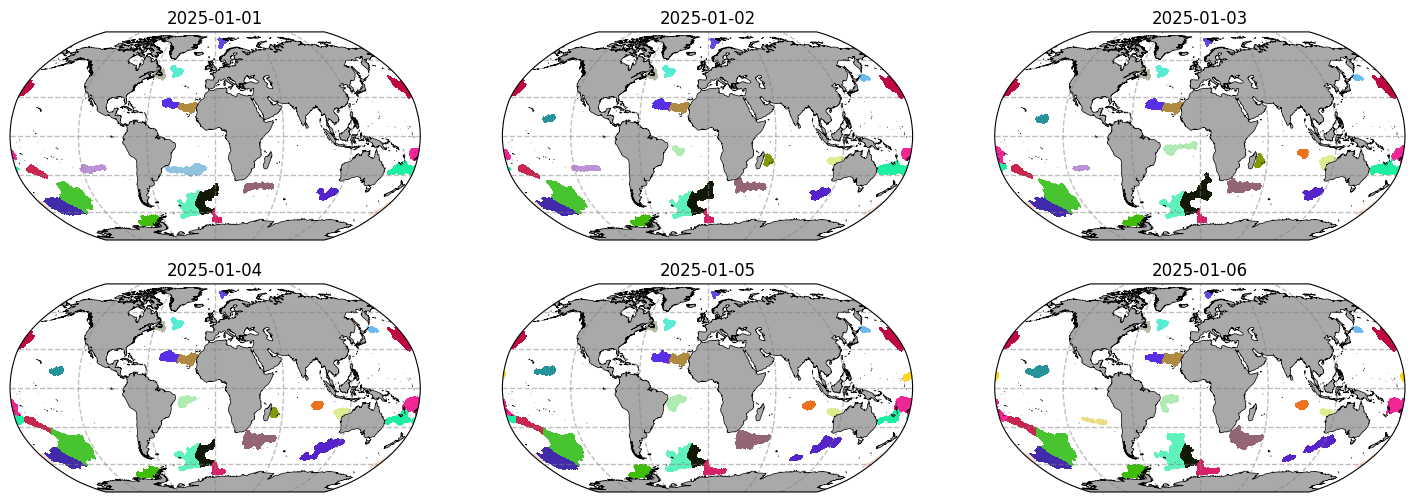

In [5]:
blobbys = blobs.sel(time=slice('2025-01-01', '2025-01-06'))
blobbys = blobbys.where(blobbys>0) 
fig, ax = blobbys.plotter.pplot_col(plot_IDs=True, col_wrap=3, show_colorbar=False)

## Plot some Blobby Shapes (1 Each Month)

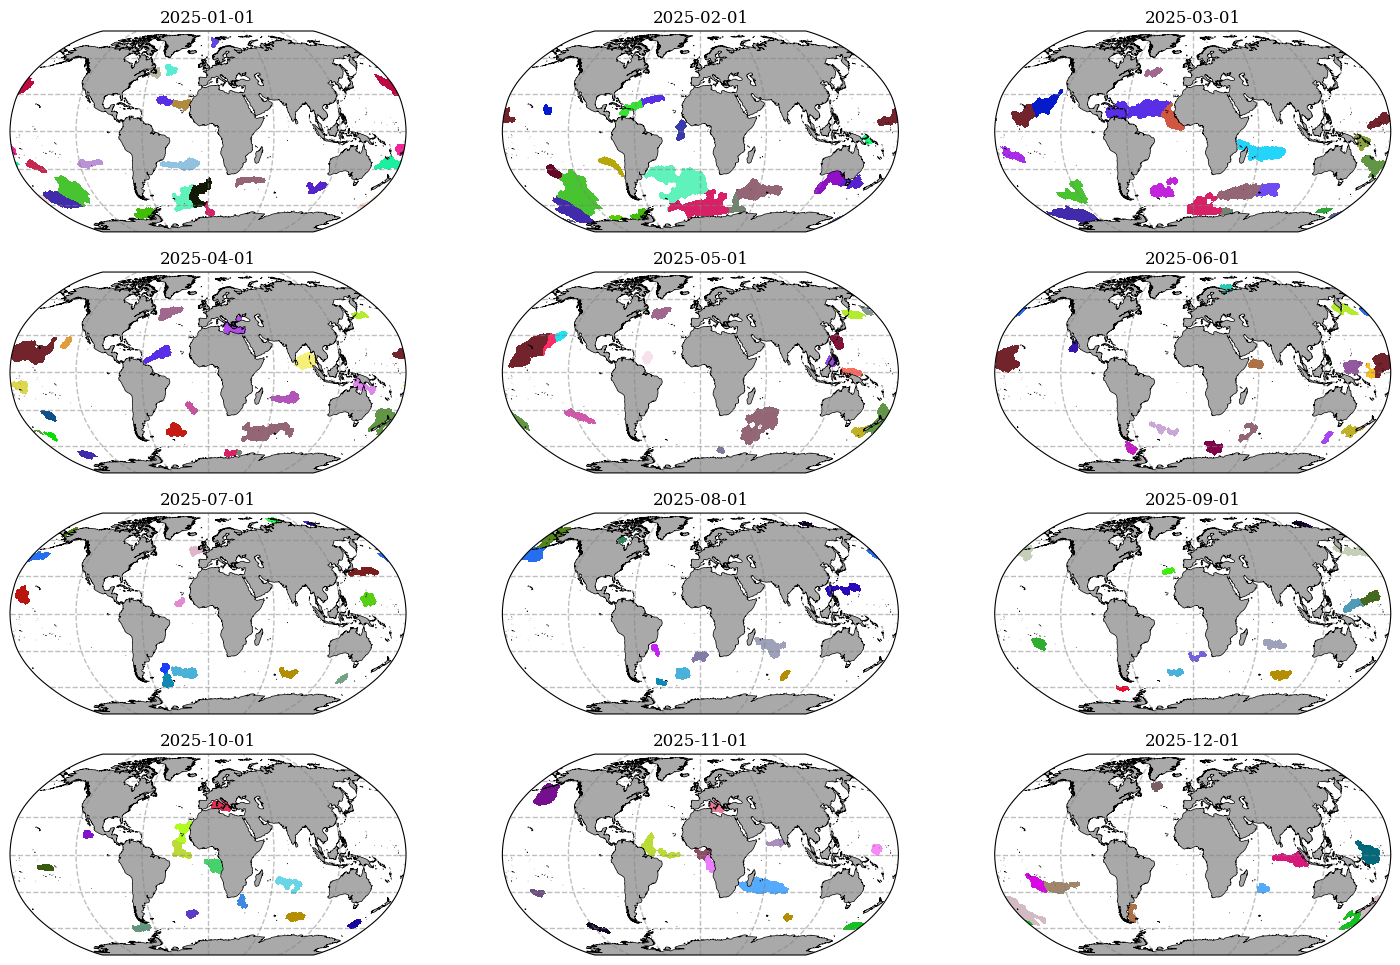

In [6]:
blobs_day1 = blobs.sel(time=slice('2025-01-01', '2025-12-31')).resample(time='MS').first()
blobs_day1 = blobs_day1.where(blobs_day1>0)
fig, ax = blobs_day1.plotter.pplot_col(plot_IDs=True, col_wrap=3, show_colorbar=False)


## Global Blob Frequency

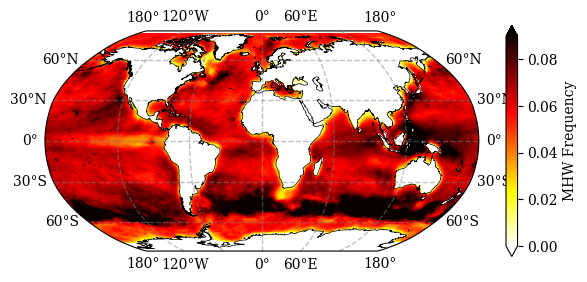

In [7]:
event_frequency = (blobs > 0).astype(float).mean('time')
fig, ax = event_frequency.plotter.pplot(var_units='MHW Frequency', cmap='hot_r', cperc=[0,96])

## Find & Plot a Few of the Longest Events

In [6]:
events_duration = blobs_ds.time_end - blobs_ds.time_start
longest_events = events_duration.sortby(events_duration, ascending=False).ID

for ID in longest_events[:10].values:
    print(f"ID: {ID:<6}   Start Day: {blobs_ds.time_start.sel(ID=ID).dt.strftime('%Y-%m-%d').values}  -->  Duration: {events_duration.sel(ID=ID).dt.days.values:<4} days")

ID: 8331     Start Day: 2028-10-22  -->  Duration: 520  days
ID: 8332     Start Day: 2028-10-22  -->  Duration: 454  days
ID: 8197     Start Day: 2028-05-25  -->  Duration: 444  days
ID: 8325     Start Day: 2028-10-15  -->  Duration: 442  days
ID: 8622     Start Day: 2029-10-22  -->  Duration: 411  days
ID: 1912     Start Day: 2008-05-12  -->  Duration: 408  days
ID: 8439     Start Day: 2029-03-05  -->  Duration: 337  days
ID: 371      Start Day: 2003-03-27  -->  Duration: 328  days
ID: 6858     Start Day: 2024-04-28  -->  Duration: 294  days
ID: 4246     Start Day: 2016-01-09  -->  Duration: 285  days


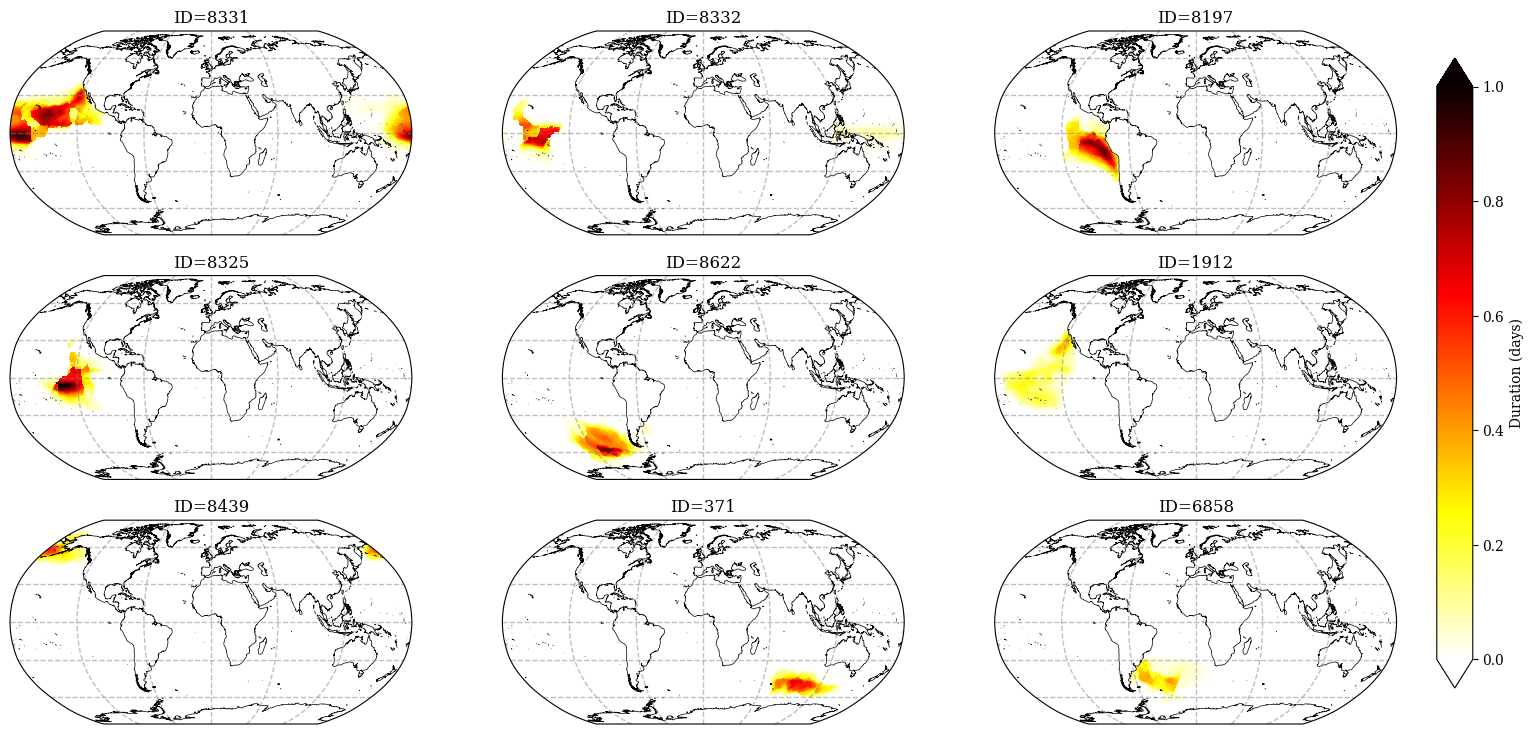

In [9]:
long_blobs = blobs == (longest_events[:9]).chunk({'ID':1})
long_blobs_local_duration = (long_blobs > 0).sum('time')

fig, ax = long_blobs_local_duration.plotter.pplot_col(col='ID', col_wrap=3, var_units='Duration (days)', cmap='hot_r', cperc=[0, 100])

## ID Min, Max, and Mean Event Area

In [5]:
# Calculate grid areas
R_earth = 6371. #km
resolution = 0.25 #deg

lat_r, lon_r, dlat, dlon = np.radians(blobs.lat), np.radians(blobs.lon), np.radians(resolution), np.radians(resolution)
grid_area = (R_earth**2 * np.abs(np.sin(lat_r + dlat/2) - np.sin(lat_r - dlat/2)) * dlon).astype(np.float32)

In [6]:
IDs = xr.DataArray(blobs_ds.ID).chunk(chunks={'ID':200})

In [9]:
# This isn't particularly efficient, aber ach was... Unstructured tracking has many lat/lon grid-related biases anyways !
areas_max = ((blobs == IDs).sum('lon') * grid_area).sum('lat').max('time').persist()

/home/b/b382615/opt/anaconda3/lib/python3.10/site-packages/dask/array/core.py:4992: PerformanceWarning: Increasing number of chunks by factor of 59
  result = blockwise(
/home/b/b382615/opt/anaconda3/lib/python3.10/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 88.82 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


## Time-Series Plot of Events Area

/home/b/b382615/opt/anaconda3/lib/python3.10/site-packages/dask/array/core.py:1709: FutureWarning: The `numpy.nanpercentile` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(
/home/b/b382615/opt/anaconda3/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/home/b/b382615/opt/anaconda3/lib/python3.10/site-packages/dask/array/core.py:1709: FutureWarning: The `numpy.nanpercentile` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(
/home/b/b382615/opt/anaconda3/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


Text(0, 0.5, 'Rough Event Area [km^2]')

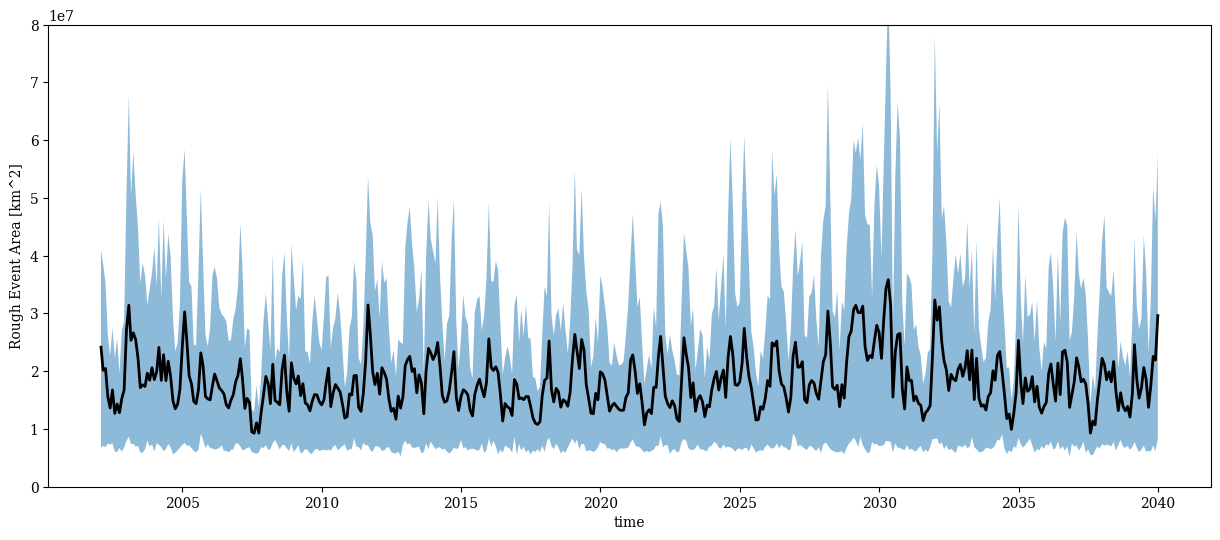

In [10]:
events_areas = blobs_ds.area * 1.0e5/16.0 # km^2 (very rough estimate, since "area" here is in units of 0.25x0.25 degree grid cells...)

area_mean = events_areas.mean('ID').resample(time='ME').mean()

area_10 = events_areas.reduce(np.nanpercentile, q=10, dim='ID').resample(time='ME').mean()
area_90 = events_areas.reduce(np.nanpercentile, q=90, dim='ID').resample(time='ME').mean()

plt.figure(figsize=(15, 6))
area_mean.plot(label='Mean Area', color='k', lw=2)
plt.fill_between(area_mean.time.values, area_10, area_90, alpha=0.5)
#plt.yscale('log')
plt.ylim([0, 8e7])
plt.ylabel('Rough Event Area [km^2]')


## Hovmüller Plot of MHW Monthly Frequency vs Latitude

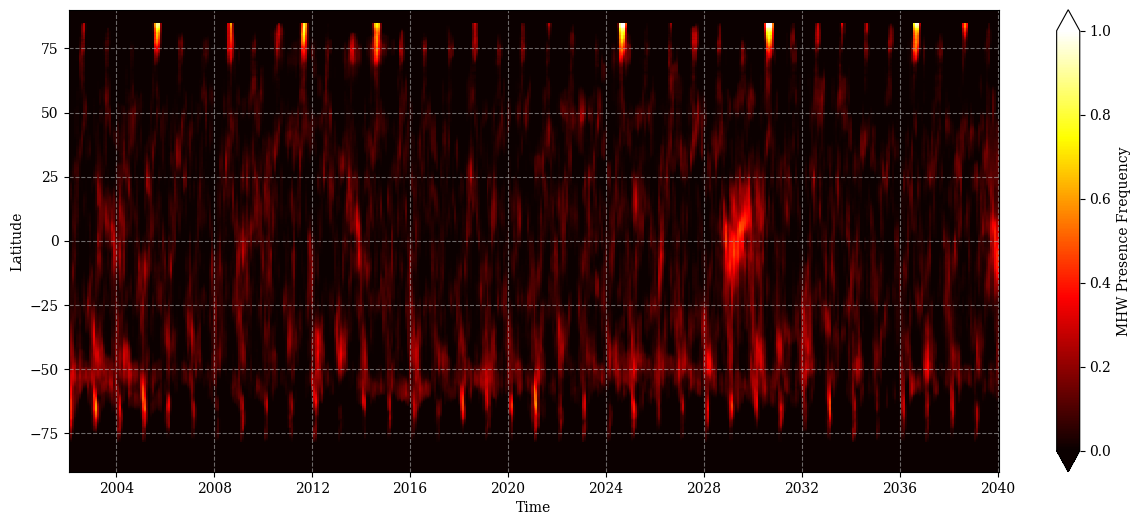

In [11]:
spatial_presence = (blobs > 0).mean(dim='lon').resample(time='ME').mean()

fig, ax = plt.subplots(figsize=(15, 6))
im = spatial_presence.plot(ax=ax, cmap='hot', x='time',
    cbar_kwargs={
        'label': 'MHW Presence Frequency',
        'extend': 'both'})

ax.set_xlabel('Time')
ax.set_ylabel('Latitude')
ax.grid(True, linestyle='--', alpha=0.6)


## Seasonal Cycle of MHW vs Latitude

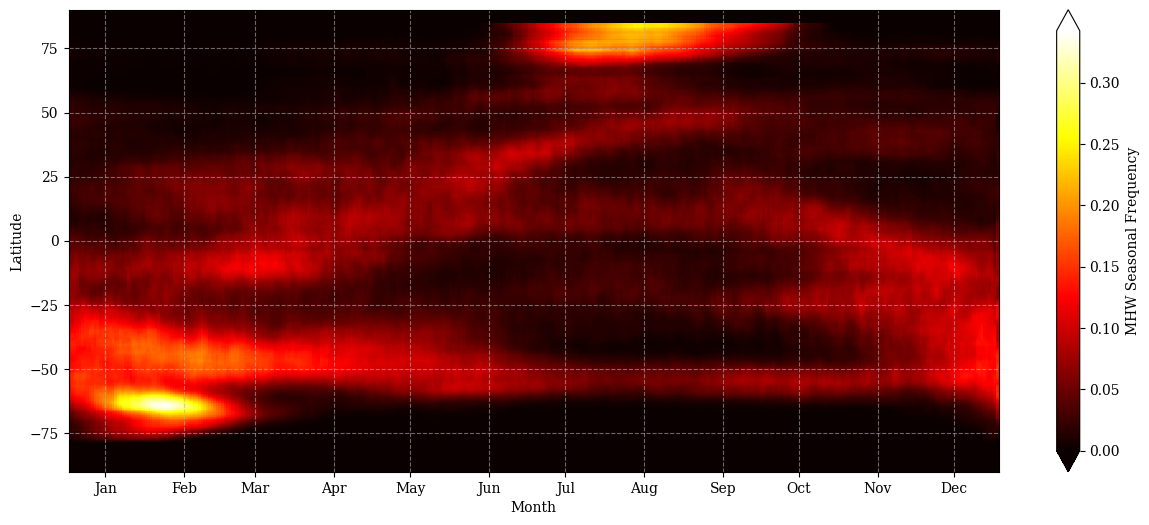

In [12]:
spatial_presence_seasonal = (blobs > 0).mean(dim='lon').groupby('time.dayofyear').mean()

fig, ax = plt.subplots(figsize=(15, 6))
im = spatial_presence_seasonal.plot(ax=ax, cmap='hot', x='dayofyear',
    cbar_kwargs={
        'label': 'MHW Seasonal Frequency',
        'extend': 'both'})

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
days_per_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
month_positions = np.cumsum([0] + days_per_month[:-1]) + 15

ax.set_xticks(month_positions)
ax.set_xticklabels(months)
ax.set_xlabel('Month')
ax.set_ylabel('Latitude')
ax.grid(True, linestyle='--', alpha=0.6)
